In [1]:
import copy
import matplotlib.pyplot as plt

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

from joblib import Parallel, delayed

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in (train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


# Define the neural network
class Net(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x
# DEVICE = "cuda"
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 40
from devinterp.slt import estimate_learning_coeff

# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
def rlct_estimate(model, sampling_method, lr=None, num_draws=None, ):
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
        verbose=False,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
        verbose=False,
    )
    print(rlct_estimate_sgld, rlct_estimate_sgnht)
    return rlct_estimate_sgnht, rlct_estimate_sgld
from tqdm import tqdm

def train_model_size(hidden_layer_size, n_epochs=20, lr=0.005, verbose=False):
    train_loss_trajectories = []
    test_loss_trajectories = []
    model = Net(hidden_layer_sizes=hidden_layer_size).to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    
    if verbose:
        loop = tqdm(range(n_epochs))
    else:
        loop = range(n_epochs)
    
    for _ in loop:
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        test_loss = evaluate(model, test_loader, criterion)
        train_loss_trajectories.append(train_loss)
        test_loss_trajectories.append(test_loss)
        # print(f"Model size {hidden_layer_size} Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")
    return model, train_loss_trajectories, test_loss_trajectories

60000


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_learning_coeff_trace(trace: pd.DataFrame, **kwargs):

    for chain, df in trace.groupby("chain"):
        plt.plot(df["step"], df["loss"], label=f"Chain {chain}", **kwargs)

    plt.xlabel("Step")
    plt.ylabel(r"$L_n(w)$")
    plt.title("Learning Coefficient Trace")
    plt.legend()
    plt.gcf().set_size_inches(16, 8)
    plt.show()

### Expt start here

In [3]:
hidden_layer_size = [1024]
torch.manual_seed(0)
model, train_losses, test_losses = train_model_size(hidden_layer_size, n_epochs=20, lr=0.005, verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


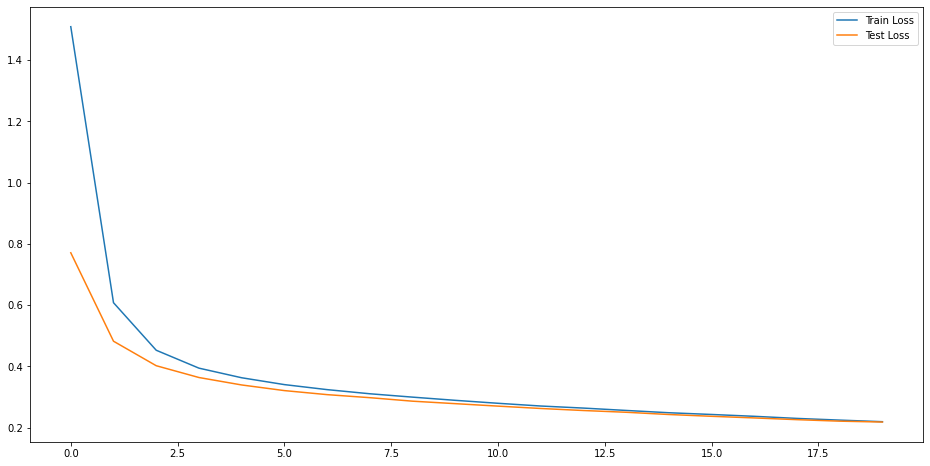

In [4]:
# plot the learning curve
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.gcf().set_size_inches(16, 8)
plt.show()

In [5]:
from devinterp.slt.rlct_tune_utils import *
# sweep over hyperparams, storing rlct estimate summary
hyperparams = {
    "lr_list": [1e-5],
    "restrict_to_orth_grad_list": [True, False],
    "optimizer_list": [SGNHT],
    "num_samples": [len(train_data)],

    # SGNHT
    "diffusion_factor_list": [0.01],

    # SGLD
    "noise_level_list": [0.5, 1.0, 2.0],
    "elasticity_list": [100.0, 200.0, 300.0],
    "temperature_list": ['adaptive', 1.0, 2.0],

    # chain config
    "num_draws": [200],
    "num_chains": [1],
}

# run parallel jobs
args_list = make_args_list(**hyperparams)
# print(args_list)
rlct_estimate_summary_list = Parallel(n_jobs=8, verbose=10)(
    delayed(get_summary_for_hyperparams)(copy.deepcopy(model), args) 
    for args in args_list)
# rlct_estimate_summary_list = [get_summary_for_hyperparams(copy.deepcopy(model), args) for args in args_list]
# print(args_list)

{'lr': 1e-05, 'optimizer': <class 'devinterp.optim.sgnht.SGNHT'>, 'diffusion_factor': 0.01, 'num_draws': 200, 'restrict_to_orth_grad': True, 'num_samples': 60000, 'num_chains': 1}
{'lr': 1e-05, 'optimizer': <class 'devinterp.optim.sgnht.SGNHT'>, 'diffusion_factor': 0.01, 'num_draws': 200, 'restrict_to_orth_grad': False, 'num_samples': 60000, 'num_chains': 1}


lr: 1e-05, SGNHT, diffusion_factor: 0.01, num_draws: 200, restrict_to_orth_grad: True, num_samples: 60000, num_chains: 1, 
lr: 1e-05, SGNHT, diffusion_factor: 0.01, num_draws: 200, restrict_to_orth_grad: False, num_samples: 60000, num_chains: 1, 


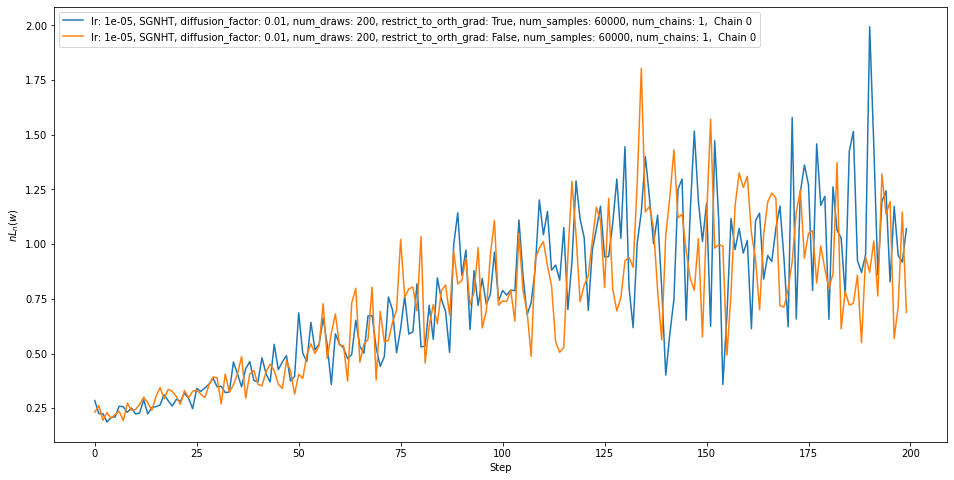

In [6]:
# plot summary traces
args_list = make_args_list(**hyperparams)
for rlct_estimate_summary, args in zip(rlct_estimate_summary_list, args_list):
    # make label out of args
    label = ""
    for key, value in args.items():
        if key == "optimizer":
            label += f"{value.__name__}, "
        else:
            label += f"{key}: {value}, "
    print(label)
    trace = rlct_estimate_summary['trace']
    for chain, df in trace.groupby("chain"):
        plt.plot(df["step"], df["loss"], label= f"{label} Chain {chain}")
plt.xlabel("Step")
plt.ylabel(r"$L_n(w)$")
plt.legend()
plt.gcf().set_size_inches(16, 8)

In [7]:
[(rlct_estimate_summary_list[i]['mean'], rlct_estimate_summary_list[i]['std']) for i in range(len(rlct_estimate_summary_list))]

[(2563.284912109375, nan), (2683.649658203125, nan)]